# Blood Cell Classifier

## 1) Take a look at sample of the data

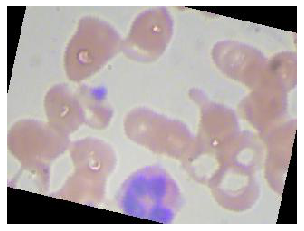

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
from os import walk
DATADIR = "Blood Cell Images\dataset2-master\dataset2-master\images"


f = []
for (dirpath, dirnames, filenames) in walk(DATADIR):
    f.extend(dirnames)
    break
    
category=[]
for (dirpath, dirnames, filenames) in walk(os.path.join(DATADIR,f[0])):
    category.extend(dirnames)
    break
    


path = os.path.join(DATADIR,f[0],category[0])
for img in os.listdir(path):  # iterate over each image per dogs and cats
    img_array = cv2.imread(os.path.join(path,img))  # convert to array
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    plt.imshow(img_array)  # graph it
    plt.axis("off")
    plt.show()  # display!

    break  # we just want one for now so break
img_array.shape

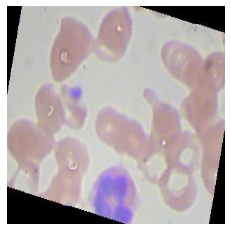

In [22]:
IMG_SIZE = 224

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array)
plt.axis("off")
plt.show()


## 2) Load the Data

In [38]:
training_data = []

def create_training_data():
    for file in f: 
        for label in category:
            path = os.path.join(DATADIR,file,label) 
            for img in tqdm(os.listdir(path)): 
                try:
                    img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE) 
                    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
                    training_data.append([new_array, label])  # add this to our training_data
                except Exception as e:  # in the interest in keeping the output clean...
                    pass
                #except OSError as e:
                #    print("OSErrroBad img most likely", e, os.path.join(path,img))
                #except Exception as e:
                #    print("general exception", e, os.path.join(path,img))

create_training_data()

print(len(training_data))


100%|████████████████████████████████████████████████████████████████████████████| 2499/2499 [00:01<00:00, 1980.82it/s]

12515


In [39]:
import random

random.shuffle(training_data)

In [40]:
for sample in training_data[:10]:
    print(sample[1])

MONOCYTE
NEUTROPHIL
NEUTROPHIL
LYMPHOCYTE
NEUTROPHIL
LYMPHOCYTE
EOSINOPHIL
MONOCYTE
MONOCYTE
NEUTROPHIL


## 3) Visualize the dataset

In [41]:
def show_batch(image_batch,label_batch): # see a batch of  the  data to better understand it
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n], cmap='gray')
        plt.title(label_batch[n])
        plt.axis("off")

12515
(12515, 1)
[['MONOCYTE']
 ['NEUTROPHIL']
 ['NEUTROPHIL']
 ...
 ['LYMPHOCYTE']
 ['MONOCYTE']
 ['EOSINOPHIL']]
(12515, 4) (12515, 224, 224, 1)


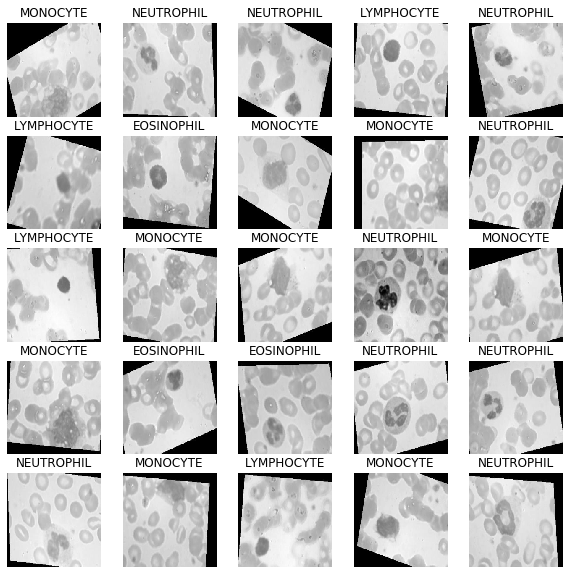

In [42]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

X = []
y = []
print(len(training_data))
for features,label in training_data:
    X.append(features)
    y.append(label)
show_batch(X,y)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y=np.array(y).reshape(-1, 1)
print(y.shape)
print(y)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

y=to_categorical(y)
print(y.shape,X.shape)

In [43]:
def show_batch_predicted(image_batch): # see the same batch after prediction from the model
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n], cmap='gray')
        pred=model.predict(np.array(image_batch[n]).reshape(1, IMG_SIZE, IMG_SIZE, 1))
        label=np.argmax(pred,axis=1)
        if label[0] == 0:
            plt.title(category[0])
        elif label[0] == 1:
            plt.title(category[1])
        elif label[0] == 2:
            plt.title(category[2])
        elif label[0] == 3:
            plt.title(category[3])
        plt.axis("off")

In [44]:
print(X.shape,y.shape)

(12515, 224, 224, 1) (12515, 4)


## 4) Correct for data imbalance

In [45]:
counts=[]
num_classes=4
for i in range(num_classes):
    counts.append(y[:,i].astype(bool).sum(axis=0))
counts

[3133, 3109, 3102, 3171]

In [46]:
for i in range (num_classes):
    counts[i] = (1 / counts[i])*(len(X))/float(num_classes)

print(counts)
class_weight = {i: counts[i] for i in range(num_classes)}

[0.9986434727098628, 1.0063525249276295, 1.0086234687298516, 0.9866761274046042]


## 5) Split the training data

In [47]:
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

print(X_train.shape)

(10012, 224, 224, 1)


## 6) Build the CNN

In [48]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Convolution2D,SeparableConv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import Input, Lambda, Conv2D, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D, Input, Add
from keras.models import load_model, Model
# from keras.layers.merge import add

In [49]:
def conv_block(clf,filters,kernel_size,skip=True):
    for i in range(2):
        clf=SeparableConv2D(filters=filters, kernel_size=kernel_size, padding='same')(clf)
        clf=BatchNormalization(epsilon=0.001)(clf)
        clf=LeakyReLU(alpha=0.1)(clf)
    
    skip_connection = clf
    for i in range(2):
        clf=SeparableConv2D(filters=filters, kernel_size=kernel_size, padding='same')(clf)
        clf=BatchNormalization(epsilon=0.001)(clf)
        clf=LeakyReLU(alpha=0.1)(clf)
    
    return Add()([skip_connection, clf]) if skip else clf

def dense_block(clf,units, dropout_rate):
    
    clf=Dense(units,activation='relu')(clf)
    clf=BatchNormalization(epsilon=0.001)(clf)
    clf=Dropout(dropout_rate)(clf)
    
    return clf

In [50]:
def build_model():
    input_image = Input(shape=X_train.shape[1:])
    clf=Convolution2D(filters=16, kernel_size=3, padding='same')(input_image)
    clf=Convolution2D(filters=16, kernel_size=3, padding='same')(clf)
    clf=MaxPooling2D(pool_size=2)(clf)
    clf=conv_block(clf,32,3)
    clf=MaxPooling2D(pool_size=2)(clf)
    
    clf=conv_block(clf,64,3)
    clf=MaxPooling2D(pool_size=2)(clf)
    
    clf=conv_block(clf,128,3)
    clf=MaxPooling2D(pool_size=2)(clf)
    clf=Dropout(.2)(clf)
    
    clf=conv_block(clf,256,3)
    clf=MaxPooling2D(pool_size=2)(clf)
    clf=Dropout(.2)(clf)
    
    clf=conv_block(clf,256,3)
    clf=MaxPooling2D(pool_size=2)(clf)
    clf=Dropout(.2)(clf)
    
    clf=Flatten()(clf)
    clf=dense_block(clf,2304, 0.3)
    clf=dense_block(clf,512, 0.3)
    clf=dense_block(clf,128, 0.3)
    
    clf=Dense(4, activation='softmax')(clf)

    return Model(input_image,clf)
model=build_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 224, 224, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 112, 112, 16) 0           conv2d_2[0][0]                   
____________________

## 7) Train the model

In [51]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping,LearningRateScheduler


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


checkpoint_cb = ModelCheckpoint("Blood_Cell_model.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max', period=1)


def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = LearningRateScheduler(exponential_decay_fn)

history = model.fit(
    X_train,y_train,
    epochs=100, batch_size=32,
    validation_split=.2,verbose=1, shuffle=True,
    callbacks=[checkpoint_cb, lr_scheduler],
    class_weight=class_weight
)

Instructions for updating:
Use tf.cast instead.
Train on 8009 samples, validate on 2003 samples
Epoch 1/100
8009/8009 [==============================] - 90s 11ms/step - loss: 1.4820 - accuracy: 0.2908 - val_loss: 2.5669 - val_accuracy: 0.2586
Epoch 2/100


C:\Users\ahmed\Anaconda3\envs\deeplearning_GPU\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


8009/8009 [==============================] - 84s 10ms/step - loss: 1.1956 - accuracy: 0.4408 - val_loss: 1.8698 - val_accuracy: 0.2721
Epoch 3/100
8009/8009 [==============================] - 83s 10ms/step - loss: 0.9876 - accuracy: 0.5866 - val_loss: 8.0957 - val_accuracy: 0.3330
Epoch 4/100
8009/8009 [==============================] - 84s 10ms/step - loss: 0.6958 - accuracy: 0.7148 - val_loss: 2.1948 - val_accuracy: 0.4373
Epoch 5/100
8009/8009 [==============================] - 84s 10ms/step - loss: 0.6074 - accuracy: 0.7524 - val_loss: 6.1202 - val_accuracy: 0.2736
Epoch 6/100
8009/8009 [==============================] - 84s 10ms/step - loss: 0.4876 - accuracy: 0.8055 - val_loss: 1.6689 - val_accuracy: 0.5322
Epoch 7/100
8009/8009 [==============================] - 84s 10ms/step - loss: 0.4427 - accuracy: 0.8299 - val_loss: 2.2416 - val_accuracy: 0.4388
Epoch 8/100
8009/8009 [==============================] - 83s 10ms/step - loss: 0.3435 - accuracy: 0.8715 - val_loss: 7.9158 - val_

## 8) Visualizing model performance

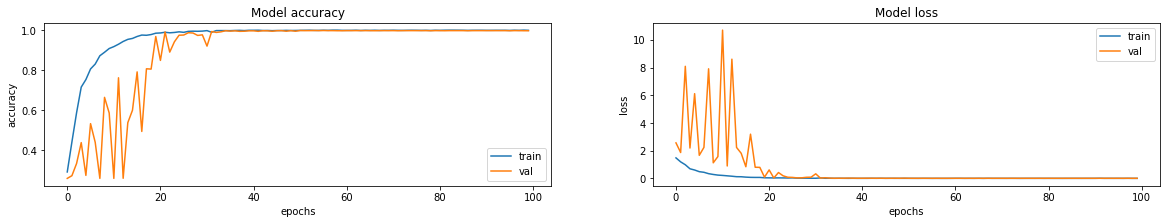

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## 9) Predict and evaluate results

In [53]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100)

2503/2503 [==============================] - 5s 2ms/step
Test loss: 0.01709595061974146
Test accuracy: 99.60048198699951


In [54]:
model.save('Blood_Cell_model.h5')

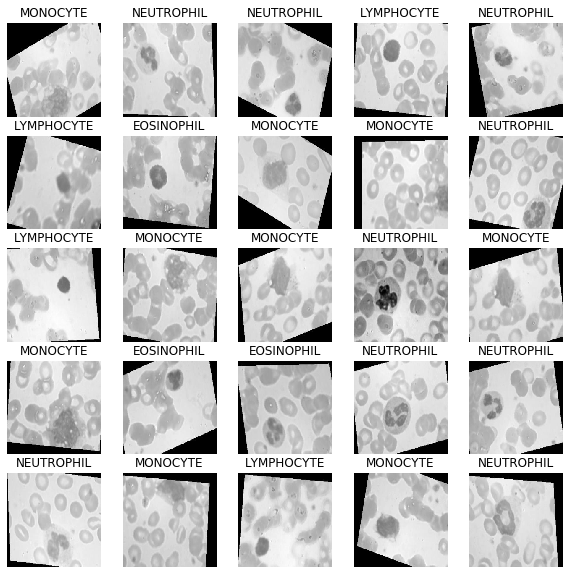

In [55]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)
show_batch(X,y)

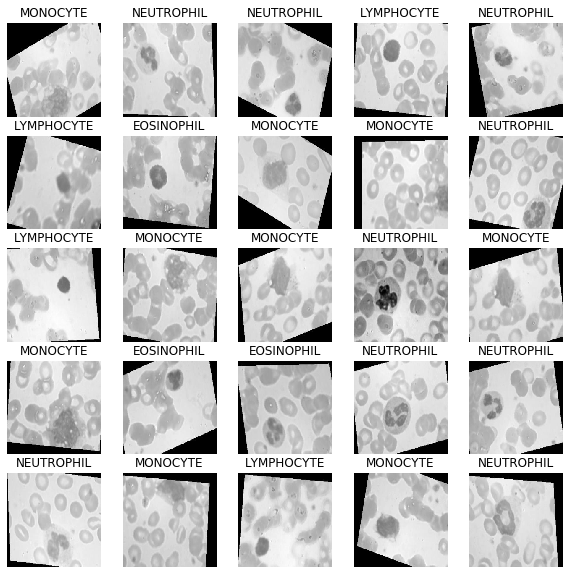

In [56]:
show_batch_predicted(X)